In [1]:
!pip install --upgrade tensorflow keras keras-cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 17.0 MB/s eta 0:00:00


In [2]:
!wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz
!tar xvzf data.tgz

--2023-06-04 12:11:00--  https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/sakfqp6o8pbgasm/data.tgz [following]
--2023-06-04 12:11:00--  https://www.dropbox.com/s/raw/sakfqp6o8pbgasm/data.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4341ab36fd443ca1b8eba233ca.dl.dropboxusercontent.com/cd/0/inline/B9UVfPd0L8-simBPJUUt5BHXaZ3SbQ3pm0DpVBsXQfElddBhCjdu5mJhlo1iGfvTqOATqJyj8dV0V-6AElyacPpl69UF6zxZCYJw4386A1_22nV5vPEEeQt6i4Yogu5JGiBTfFcAczYdboHpYSppW0qDBPV6OVxaptovbSLl5owe0w/file# [following]
--2023-06-04 12:11:03--  https://uc4341ab36fd443ca1b8eba233ca.dl.dropboxusercontent.com/cd/0/inline/B9UVfPd0L8-simBPJUUt5BHXaZ3SbQ3pm0DpVBsXQfElddBhCjdu5mJhlo1iGfvTqOATqJyj8dV0V-6AElyacPpl69UF

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function

import tensorflow as tf
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Resizing, Rescaling, Lambda
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN

from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import AdamW, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint

In [4]:
batch_size = 32
num_classes = 20
epochs = 50

(791, 250, 250, 3)
(791,)
(784, 250, 250, 3)
(784,)


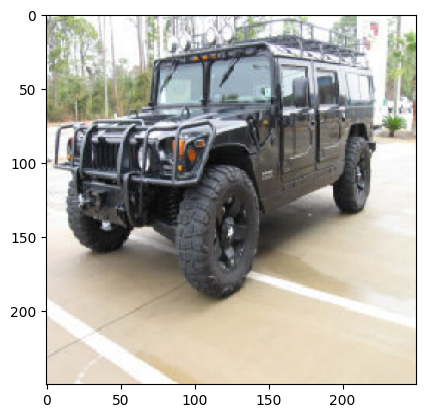

In [5]:

# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

## View some images
plt.imshow(x_train[2,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255


## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

In [7]:
def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,31*31)								  # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt, dim=1)								              # Apply l2 normalization
  return z_l2

In [12]:
# Early Stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=1,
    mode=min
)
#Checkpoint
mc = ModelCheckpoint(
    'best_m.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [17]:
vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=x_train.shape[1:], pooling=None)
for layer in vgg16.layers:
    layer.trainable = False

d1=Dropout(0.5)(vgg16.layers[-1].output)
d2=Dropout(0.5)(vgg16.layers[-1].output)

x = Lambda(outer_product, name='outer_product')([d1,d2])
adam=AdamW()
lr_schedule =ReduceLROnPlateau()
predictions=Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=predictions)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 250, 250, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 250, 250, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [18]:
def plot_evolution(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 2.9850 - accuracy: 0.0738
Epoch 1: val_accuracy did not improve from 0.44005
24/24 [==============================] - 98s 4s/step - loss: 2.9850 - accuracy: 0.0738 - val_loss: 2.8807 - val_accuracy: 0.1327 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 2.8433 - accuracy: 0.1765
Epoch 2: val_accuracy did not improve from 0.44005
24/24 [==============================] - 17s 718ms/step - loss: 2.8433 - accuracy: 0.1765 - val_loss: 2.7610 - val_accuracy: 0.1913 - lr: 0.0010
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 2.7308 - accuracy: 0.2622
Epoch 3: val_accuracy did not improve from 0.44005
24/24 [==============================] - 16s 688ms/step - loss: 2.7308 - accuracy: 0.2622 - val_loss: 2.6631 - val_accuracy: 0.3253 - lr: 0.0010
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 2.6365 - accuracy: 0.3333
Epoch 4: val_accuracy did not improve f

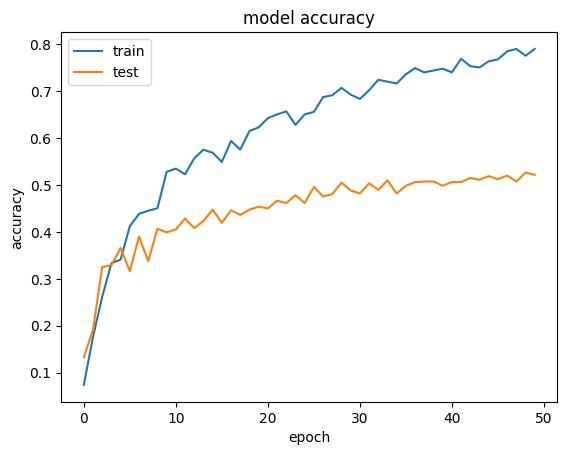

In [19]:
history=model.fit(datagen.flow(x_train, y_train,batch_size),
                    steps_per_epoch=len(x_train) // batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[es,mc,lr_schedule],
                    verbose=1)
plot_evolution(history)

In [20]:
for layer in vgg16.layers:
    layer.trainable = True
opt = AdamW(learning_rate=1e-5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=1e-9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 0.9055 - accuracy: 0.7958
Epoch 1: val_accuracy improved from 0.52679 to 0.57398, saving model to best_m.h5
24/24 [==============================] - 51s 1s/step - loss: 0.9055 - accuracy: 0.7958 - val_loss: 1.3470 - val_accuracy: 0.5740 - lr: 1.0000e-05
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.7112 - accuracy: 0.8393
Epoch 2: val_accuracy did not improve from 0.57398
24/24 [==============================] - 25s 1s/step - loss: 0.7112 - accuracy: 0.8393 - val_loss: 1.3266 - val_accuracy: 0.5727 - lr: 1.0000e-05
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.6362 - accuracy: 0.8485
Epoch 3: val_accuracy improved from 0.57398 to 0.59184, saving model to best_m.h5
24/24 [==============================] - 28s 1s/step - loss: 0.6362 - accuracy: 0.8485 - val_loss: 1.2798 - val_accuracy: 0.5918 - lr: 1.0000e-05
Epoch 4/50
24/24 [==============================] - ETA: 0s - los

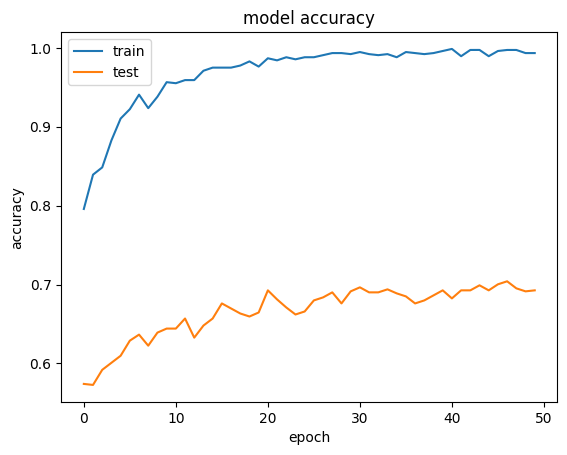

In [21]:
history=model.fit(datagen.flow(x_train, y_train,batch_size),
                    steps_per_epoch=len(x_train) // batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[es,mc,lr_schedule],
                    verbose=1)
plot_evolution(history)

In [22]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

25/25 [==============================] - 4s 176ms/step - loss: 0.9683 - accuracy: 0.6926
Test loss: 0.9683080315589905
Test accuracy: 0.6926020383834839


In [23]:
from tensorflow.keras.models import load_model

In [24]:
# load the saved model
saved_model = load_model('best_m.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.995, Test: 0.704
